In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
cowpea = pd.read_excel('../data/prepared.xlsx', sheet_name='Cowpea')
maize = pd.read_excel('../data/prepared.xlsx', sheet_name='Maize')
rice = pd.read_excel('../data/prepared.xlsx', sheet_name='Rice')
chickpea = pd.read_excel('../data/prepared.xlsx', sheet_name='Chickpea')
mustard = pd.read_excel('../data/prepared.xlsx', sheet_name='Mustard')

In [3]:
X_mustard = mustard[['GSR','CT']]
y_mustard = mustard['Rn']

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [5]:
model = Sequential()
model.add(Dense(16, input_shape=(2,), activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='relu'))

In [6]:
print("Model input shape:", model.input_shape)
print("Model output shape:", model.output_shape)

Model input shape: (None, 2)
Model output shape: (None, 1)


In [7]:
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [8]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                48        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model.fit(X_mustard, y_mustard, validation_split=0.25, epochs=6000, batch_size=256, verbose=0)

In [10]:
print("Training loss:", history.history['loss'][-1])
print("Validation loss:", history.history['val_loss'][-1])

if 'root_mean_squared_error' in history.history.keys():
    print("Training loss:", history.history['root_mean_squared_error'][-1])
    print("Validation loss:", history.history['val_root_mean_squared_error'][-1])

Training loss: 8464.302734375
Validation loss: 14865.5322265625
Training loss: 92.00164794921875
Validation loss: 121.92428588867188


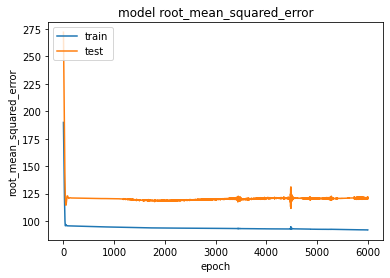

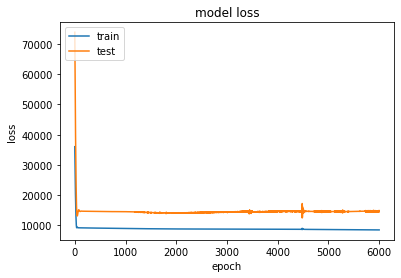

In [12]:
# summarize history for accuracy
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model root_mean_squared_error')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()